In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

%matplotlib inline
pd.set_option("display.max_rows",None,"display.max_columns", None)
warnings.simplefilter(action='ignore')
plt.style.use('seaborn')


# Prediccion de precios de carros con algoritmo de redes neuronales

In [2]:
df = pd.read_csv('car data.csv')
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


## Analisis exploratorio de datos
#### Se procede a obtener las dimensiones del dataset, asi como tambien la información del tipo de dato que contiene cada columna y el uso en memoria. Por ultimo obtenemos los datos estadisticos del modelo y la verificacion de si existen datos nulos o no.


In [3]:
#Obtenemos las dimensiones del dataframe
df.shape

(301, 9)

In [4]:
#Obtenemos la informacion de dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [5]:
#Obtenemos los datos estadisticos del dataframe
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [6]:
df.isna().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [7]:
df['Age'] = 2021 - df['Year']
df.drop('Year', axis=1, inplace=True)
#Obtenemos la edad del carro y ademas eliminamos la columna del año

In [8]:
df.head()

,Car_Name,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Age
0,ritz,3.35,5.59,27000,Petrol,Dealer,Manual,0,7
1,sx4,4.75,9.54,43000,Diesel,Dealer,Manual,0,8
2,ciaz,7.25,9.85,6900,Petrol,Dealer,Manual,0,4
3,wagon r,2.85,4.15,5200,Petrol,Dealer,Manual,0,10
4,swift,4.60,6.87,42450,Diesel,Dealer,Manual,0,7


In [9]:
df.rename(columns = {'Selling_Price':'Selling_Price(lacs)', 'Present_Price':'Present_Price(lacs)', 'Owner':'Past_Owners'}, inplace=True)
df.head()
#Renombramos las columnas de precio y si tenian dueños pasadas


,Car_Name,Selling_Price(lacs),Present_Price(lacs),Kms_Driven,Fuel_Type,Seller_Type,Transmission,Past_Owners,Age
0,ritz,3.35,5.59,27000,Petrol,Dealer,Manual,0,7
1,sx4,4.75,9.54,43000,Diesel,Dealer,Manual,0,8
2,ciaz,7.25,9.85,6900,Petrol,Dealer,Manual,0,4
3,wagon r,2.85,4.15,5200,Petrol,Dealer,Manual,0,10
4,swift,4.60,6.87,42450,Diesel,Dealer,Manual,0,7


In [10]:
df.columns

Index(['Car_Name', 'Selling_Price(lacs)', 'Present_Price(lacs)', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Past_Owners', 'Age'],
      dtype='object')

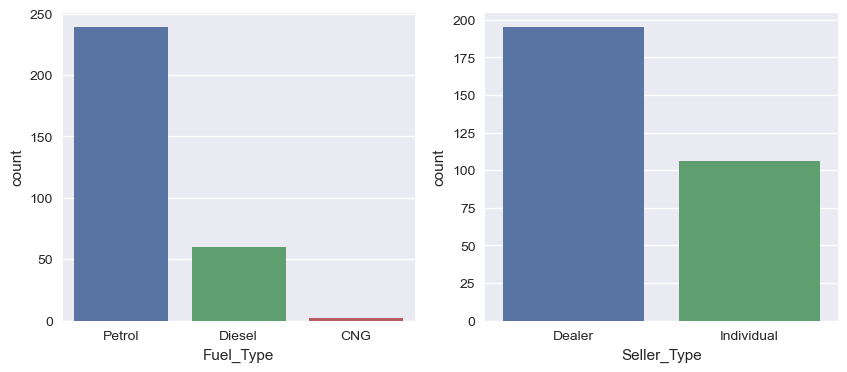

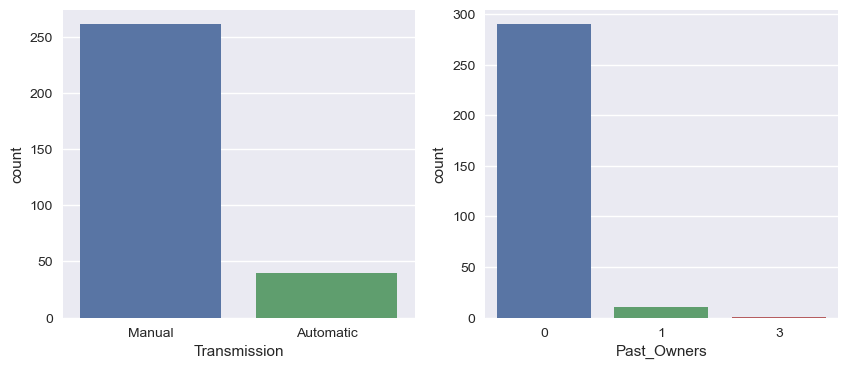

In [11]:
#Hacemos una visualizacion de los datos como el tipo de combustible, los dueños anteriores, tipos de trasnmision
cat_cols = ['Fuel_Type', 'Seller_Type', 'Transmission', 'Past_Owners']
i = 0
while i < 4:
    fig = plt.figure(figsize=[10,4])
    
    plt.subplot(1,2,1)
    sns.countplot(x=cat_cols[i], data=df)
    i +=1
    
    plt.subplot(1,2,2)
    sns.countplot(x=cat_cols[i], data=df)
    i += 1
    
    plt.show()

## Ingeniería / selección de características + limpieza de datos, Visualizacion de datos

#### Para esta parte se realiza la ingenieria de caracteristicas, que implica la extracción y transformación de variables a partir de datos sin procesar, como las listas de precios, las descripciones de los productos y los volúmenes de ventas, de modo que sea posible utilizar las características para el entrenamiento y la predicción. Para este proposito se preparan las variables que se van a utilizar. Se considera los km de recorrido, el precio actual y el precio en el cual se vende para unficar estas variables. Se calcula el percentil 99 de la columna 'Present_Price(lacs)', que es una medida estadística que indica el valor por debajo del cual cae el 99% de los puntos de datos.

In [12]:
df[df['Present_Price(lacs)']>df['Present_Price(lacs)'].quantile(0.99)]

,Car_Name,Selling_Price(lacs),Present_Price(lacs),Kms_Driven,Fuel_Type,Seller_Type,Transmission,Past_Owners,Age
64,fortuner,33.0,36.23,6000,Diesel,Dealer,Automatic,0,4
86,land cruiser,35.0,92.60,78000,Diesel,Dealer,Manual,0,11


In [13]:
df[df['Selling_Price(lacs)'] > df['Selling_Price(lacs)'].quantile(0.99)]

,Car_Name,Selling_Price(lacs),Present_Price(lacs),Kms_Driven,Fuel_Type,Seller_Type,Transmission,Past_Owners,Age
63,fortuner,23.5,35.96,47000,Diesel,Dealer,Automatic,0,6
64,fortuner,33.0,36.23,6000,Diesel,Dealer,Automatic,0,4
86,land cruiser,35.0,92.60,78000,Diesel,Dealer,Manual,0,11


In [14]:
df[df['Kms_Driven'] > df['Kms_Driven'].quantile(0.99)]

,Car_Name,Selling_Price(lacs),Present_Price(lacs),Kms_Driven,Fuel_Type,Seller_Type,Transmission,Past_Owners,Age
84,innova,3.49,13.46,197176,Diesel,Dealer,Manual,0,16
179,Honda Karizma,0.31,1.05,213000,Petrol,Individual,Manual,0,11
196,Activa 3g,0.17,0.52,500000,Petrol,Individual,Automatic,0,13


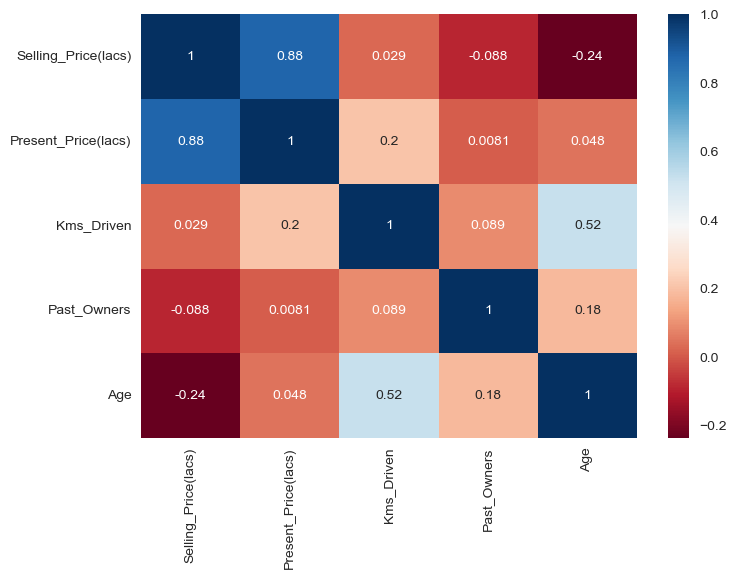

In [15]:
sns.heatmap(df.corr(), annot = True, cmap='RdBu')
plt.show()

In [16]:
df.corr()['Selling_Price(lacs)']

Selling_Price(lacs)    1.000000
Present_Price(lacs)    0.878983
Kms_Driven             0.029187
Past_Owners           -0.088344
Age                   -0.236141
Name: Selling_Price(lacs), dtype: float64

In [17]:
df.pivot_table(values='Selling_Price(lacs)', index = 'Seller_Type', columns='Fuel_Type')

Fuel_Type,CNG,Diesel,Petrol
Seller_Type,,,
Dealer,3.1,10.181525,5.252388
Individual,NaN,16.000000,0.726857


In [18]:
 #En este punto eliminamos la variable del nombre del carro del dataset
df.drop(labels='Car_Name', axis=1, inplace = True)

In [19]:
df.head()

,Selling_Price(lacs),Present_Price(lacs),Kms_Driven,Fuel_Type,Seller_Type,Transmission,Past_Owners,Age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,7
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,8
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,4
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,10
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,7


In [20]:

df = pd.get_dummies(data=df, drop_first=True)

In [21]:
df.head()

,Selling_Price(lacs),Present_Price(lacs),Kms_Driven,Past_Owners,Age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,27000,0,7,0,1,0,1
1,4.75,9.54,43000,0,8,1,0,0,1
2,7.25,9.85,6900,0,4,0,1,0,1
3,2.85,4.15,5200,0,10,0,1,0,1
4,4.60,6.87,42450,0,7,1,0,0,1


In [22]:
X = df.iloc[:,1:].values
y = df.iloc[:,:1].values

print(X)

[[5.5900e+00 2.7000e+04 0.0000e+00 ... 1.0000e+00 0.0000e+00 1.0000e+00]
 [9.5400e+00 4.3000e+04 0.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [9.8500e+00 6.9000e+03 0.0000e+00 ... 1.0000e+00 0.0000e+00 1.0000e+00]
 ...
 [1.1000e+01 8.7934e+04 0.0000e+00 ... 1.0000e+00 0.0000e+00 1.0000e+00]
 [1.2500e+01 9.0000e+03 0.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [5.9000e+00 5.4640e+03 0.0000e+00 ... 1.0000e+00 0.0000e+00 1.0000e+00]]


In [23]:
print(X.shape, y.shape)

(301, 8) (301, 1)


## Modelo de Deep learning

#### El modelo es un modelo secuencial, lo que significa que las capas se agregan una por una y que la salida de cada capa es la entrada de la siguiente. El modelo utiliza capas totalmente conectadas o densas, que se definen utilizando la clase Dense de Keras. El modelo tiene cinco capas: la primera capa tiene 30 neuronas con una función de activación ReLU, la segunda capa tiene 10 neuronas con una función de activación ReLU, la tercera capa es una nueva capa con 10 neuronas y una función de activación ReLU, la cuarta capa es otra nueva capa con 5 neuronas y una función de activación ReLU, y la última capa tiene una sola neurona sin función de activación, que es la salida del modelo. El modelo se compila utilizando el optimizador rmsprop y la función de pérdida mse (error cuadrático medio). Esto significa que el modelo se entrenará utilizando el algoritmo de propagación hacia atrás para minimizar la función de pérdida, que es la media de los errores cuadrados entre las predicciones del modelo y las salidas reales del conjunto de datos de entrenamiento.

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

In [25]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [26]:
print(X.shape, X_train.shape, X_test.shape)

(301, 8) (240, 8) (61, 8)


In [27]:
print(y.shape, y_train.shape, y_test.shape)

(301, 1) (240, 1) (61, 1)


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu')) # Nueva capa
model.add(Dense(5, activation='relu')) # Nueva capa
model.add(Dense(1)) # Salida

model.compile(optimizer='rmsprop', loss='mse')

### Entrenamiento del modelo y validación (test, train, validation)

#### entrena el modelo de red neuronal profunda model utilizando los datos de entrenamiento y prueba proporcionados.

#### X_train es un conjunto de datos de entrenamiento que contiene las características de entrada (variables independientes).
#### y_train es un conjunto de datos de entrenamiento que contiene las etiquetas o salidas esperadas (variable dependiente) correspondientes a las características de entrada.
#### epochs=100 especifica que el modelo se entrenará durante 100 épocas completas, lo que significa que el modelo verá todo el conjunto de datos de entrenamiento 100 veces durante el entrenamiento.
#### validation_data=(X_test,y_test) se utiliza para proporcionar un conjunto de datos de validación que se utilizará para evaluar el rendimiento del modelo en datos que no ha visto durante el entrenamiento. X_test y y_test son los datos de prueba que se utilizarán para la validación.

####  En resumen, model.fit() ajusta los parámetros del modelo utilizando el algoritmo de optimización RMSprop y los datos de entrenamiento proporcionados. Durante el entrenamiento, el modelo ajustará los pesos de las neuronas en las diferentes capas de la red neuronal para minimizar la función de pérdida (error cuadrático medio en este caso) en el conjunto de datos de entrenamiento. También realizará la validación del modelo utilizando los datos de prueba y devolverá una métrica de evaluación de la precisión del modelo en los datos de entrenamiento y de prueba después de cada época.

In [29]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test))

Epoch 1/100
8/8 [==============================] - 2s 55ms/step - loss: 46.0218 - val_loss: 38.0193
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 44.0402 - val_loss: 36.4282
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 42.1474 - val_loss: 34.6170
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 40.1671 - val_loss: 32.8891
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 38.1919 - val_loss: 30.8548
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 36.0690 - val_loss: 28.8705
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 33.7846 - val_loss: 26.6395
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 31.3320 - val_loss: 24.2776
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 28.6632 - val_loss: 21.7953
Epoch 10/100
8/8 [==============================] - 0s 10ms/step - loss: 25.8376 - val_loss: 19.2748
E

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                270       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 5)                 55        
                                                                 
 dense_4 (Dense)             (None, 1)                 6         
                                                                 
Total params: 751
Trainable params: 751
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot:>

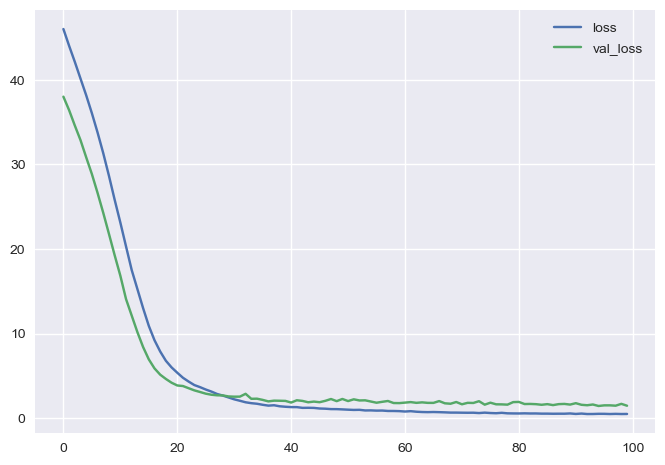

In [31]:

loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

### metricas de evaluacion 

In [32]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 0s/step - loss: 1.4680


1.4680185317993164

In [33]:
train_pred = model.predict(X_train)
# print(pred_train)

8/8 [==============================] - 0s 2ms/step


In [34]:
test_pred = model.predict(X_test)

2/2 [==============================] - 0s 0s/step


In [35]:
from sklearn.metrics import r2_score, classification_report

In [36]:
r2_train = r2_score(y_train, train_pred)
print("R Squared value of train dataL: ",r2_train)

R Squared value of train dataL:  0.9809409921963808


In [37]:
r2_test = r2_score(y_test, test_pred)
print("R Squared value of test data:", r2_test)

R Squared value of test data: 0.9323312259011329


In [38]:
diff_r2_scores = r2_train - r2_test

In [39]:
print("Difference between two scores: ", diff_r2_scores.round(2))

Difference between two scores:  0.05
